In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
from datetime import datetime

# Generate the data as you already have
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 10, 1)
date_range = pd.date_range(start=start_date, end=end_date, freq='15T')

# Function to simulate smooth temperature changes
def generate_smooth_temperature(date):
    # Get the day of the year (1 - 365) to simulate yearly temperature cycle
    day_of_year = date.timetuple().tm_yday

    # Use a sine function to simulate seasonal temperature change
    if day_of_year in range(1, 60):  # Winter (January, February)
        base_temp = -90  # cold
    elif day_of_year in range(60, 172):  # Spring (March-May)
        base_temp = -60  # warming up
    elif day_of_year in range(172, 265):  # Summer (June-August)
        base_temp = -40  # hottest
    else:  # Fall (September-November)
        base_temp = -70  # cooling down

    hour_of_day = date.hour
    temperature = base_temp + 20 * np.sin((hour_of_day + 6) * np.pi / 12)  # day-night cycle

    temperature += np.random.normal(0, 5)  # Adding random fluctuation
    return temperature

# Function to simulate smooth wind speed changes
def generate_smooth_wind(date):
    day_of_year = date.timetuple().tm_yday
    if day_of_year in range(1, 60):  # Winter
        base_wind = 15
    elif day_of_year in range(60, 172):  # Spring
        base_wind = 10
    elif day_of_year in range(172, 265):  # Summer
        base_wind = 5
    else:  # Fall
        base_wind = 10

    hour_of_day = date.hour
    wind_speed = base_wind + 5 * np.sin((hour_of_day + 6) * np.pi / 12)
    wind_speed += np.random.normal(0, 1)
    return max(0, wind_speed)  # wind cannot be negative

# Function to simulate smooth humidity changes
def generate_smooth_humidity(date):
    day_of_year = date.timetuple().tm_yday
    if day_of_year in range(1, 60):  # Winter
        base_humidity = 40
    elif day_of_year in range(60, 172):  # Spring
        base_humidity = 70
    elif day_of_year in range(172, 265):  # Summer
        base_humidity = 80
    else:  # Fall
        base_humidity = 60

    hour_of_day = date.hour
    humidity = base_humidity + 10 * np.cos((hour_of_day + 6) * np.pi / 12)
    humidity += np.random.normal(0, 5)
    return max(0, min(100, humidity))  # humidity between 0 and 100%

# Function to simulate smooth pressure changes
def generate_smooth_pressure(date):
    day_of_year = date.timetuple().tm_yday
    if day_of_year in range(1, 60):  # Winter
        base_pressure = 1025
    elif day_of_year in range(60, 172):  # Spring
        base_pressure = 1010
    elif day_of_year in range(172, 265):  # Summer
        base_pressure = 1005
    else:  # Fall
        base_pressure = 1015

    hour_of_day = date.hour
    pressure = base_pressure + 5 * np.sin((hour_of_day + 6) * np.pi / 12)
    pressure += np.random.normal(0, 2)
    return max(800, min(1100, pressure))  # pressure between 800 and 1100 hPa

# Generate the data
temperature = [generate_smooth_temperature(date) for date in date_range]
wind_speed = [generate_smooth_wind(date) for date in date_range]
humidity = [generate_smooth_humidity(date) for date in date_range]
pressure = [generate_smooth_pressure(date) for date in date_range]

# Create DataFrame with generated data
climate_data = pd.DataFrame({
    'Timestamp': date_range,
    'Temperature': temperature,
    'Pressure': pressure,
    'Wind Speed': wind_speed,
    'Humidity': humidity
})

# Convert DataFrame to JSON, but convert Timestamp to ISO 8601 string
json_data = climate_data.to_dict(orient='records')
for row in json_data:
    # Convert Timestamp to ISO 8601 string format before appending
    row['Timestamp'] = row['Timestamp'].isoformat()
    # Convert other numpy types into standard Python types
    for k, v in row.items():
        if isinstance(v, (np.int64, np.int32)):
            row[k] = int(v)
        elif isinstance(v, (np.float64, np.float32)):
            row[k] = float(v)

# Convert DataFrame to JSON
json_data = climate_data.to_dict(orient='records')

# Save to CSV file
climate_data.to_csv('/content/climate_data.csv', index=False)

print("CSV file has been saved successfully!")

<ipython-input-2-c117dc462c9e>:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='15T')


CSV file has been saved successfully!


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import matplotlib.pyplot as plt

# Load the data (assuming it's already generated and stored in climate_data.csv)
climate_data = pd.read_csv('/content/climate_data.csv')

# Normalize the data using MinMaxScaler (for deep learning)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(climate_data[['Temperature', 'Wind Speed', 'Humidity', 'Pressure']])

# Define a function to create sequences of a given time step (e.g., 30 time steps)
def create_sequences(data, time_step=30):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])  # Use previous 'time_step' values
        y.append(data[i, 0])  # Predict 'Temperature' (you can change the index for other features)
    return np.array(X), np.array(y)

# Create sequences
time_step = 30
X, y = create_sequences(scaled_data, time_step)

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape the data to match GRU input shape (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Print the shape of the data to verify
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (133224, 30, 4)
X_test shape: (33307, 30, 4)


In [ ]:
# Define the GRU model
model = Sequential()

# Add the GRU layer
model.add(GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Add another GRU layer
model.add(GRU(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(units=1))  # Predict a single value (Temperature)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 30, 64)              │          13,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,881 (89.38 KB)

 Trainable params: 22,881 (89.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4164/4164 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0067 - val_loss: 0.0018
Epoch 2/10
4164/4164 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 3/10
4164/4164 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/10
4164/4164 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 5/10
4164/4164 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/10
4164/4164 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 7/10
4164/4164 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/10
4164/4164 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 9/10
4164/4164 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 10/10
4164/4164 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 0.0021 - val_loss: 0.0018


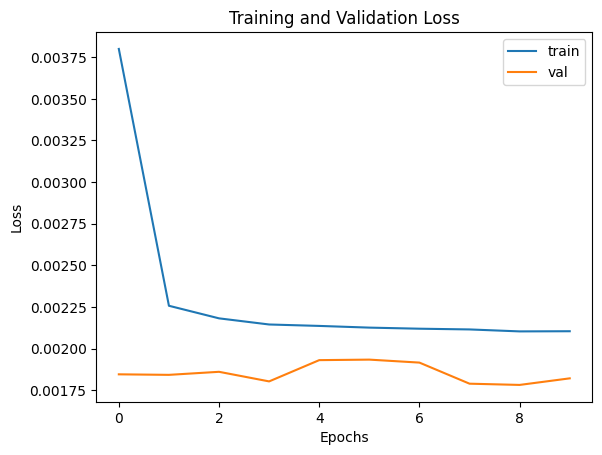

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot the training history (loss vs epoch)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0018
Test Loss: 0.0018220815109089017
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


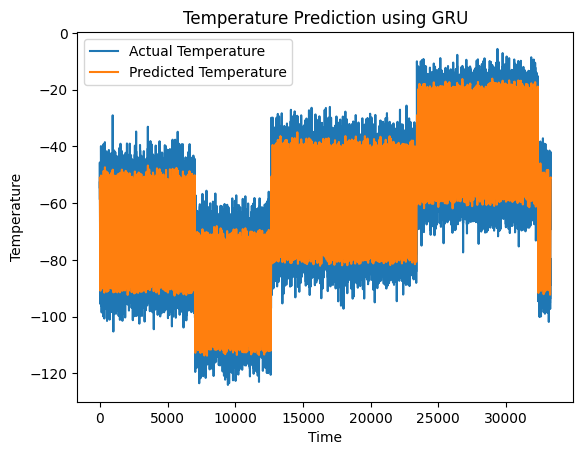

In [ ]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Invert scaling (denormalize the predicted and true values)
y_pred = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], 3))), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))), axis=1))[:, 0]

# Plot the actual vs predicted temperatures
plt.plot(y_test_inv, label='Actual Temperature')
plt.plot(y_pred, label='Predicted Temperature')
plt.title('Temperature Prediction using GRU')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import pandas as pd
from datetime import datetime, timedelta

# Function to evaluate exploration suitability
def exploration_condition(t, p, w, h):
    """ Determines whether the exploration conditions are good based on input data """
    if t > -50 and p > 700 and w <= 15 and h >= 30:
        return "Good for Exploration"
    elif t <= -50 or p <= 700 or w > 15 or h < 30:
        return "Bad for Exploration"
    else:
        return "Ideal Conditions for Exploration"

# Function to suggest the best nearby date based on user input
def suggest_best_date(model, scaler, user_input):
    """
    Suggests the best date and time for exploration based on user input and the model's prediction.

    model: The trained GRU model.
    scaler: The MinMaxScaler used to normalize the data.
    user_input: A dictionary with 'Temperature', 'Wind Speed', 'Humidity', and 'Pressure' values.
    """
    # Convert user input into a numpy array (this will be used for prediction)
    user_data = np.array([user_input['Temperature'], user_input['Wind Speed'], user_input['Humidity'], user_input['Pressure']])

    # Normalize the input data using the same scaler used for training
    user_data_scaled = scaler.transform(user_data.reshape(1, -1))

    # Reshape data for GRU prediction (the model expects sequences)
    # Here, we assume the user is looking for the next possible suitable time.
    user_sequence = np.repeat(user_data_scaled, 30, axis=0).reshape(1, 30, 4)

    # Predict future data using the GRU model (this will predict temperature)
    predicted_data = model.predict(user_sequence)

    # Inverse scale to get the actual predicted temperature
    predicted_data = scaler.inverse_transform(np.concatenate((predicted_data, np.zeros((predicted_data.shape[0], 3))), axis=1))[:, 0]

    # Get the predicted temperature and other features
    predicted_temperature = predicted_data[0]
    predicted_wind = user_input['Wind Speed']
    predicted_humidity = user_input['Humidity']
    predicted_pressure = user_input['Pressure']

    # Predict the exploration suitability
    suitability = exploration_condition(predicted_temperature, predicted_pressure, predicted_wind, predicted_humidity)

    # Get the current time and find the next best time (you could modify this logic based on the prediction)
    best_time = datetime.now() + timedelta(days=1)  # Assume one day from now for simplicity
    best_date = best_time.strftime("%Y-%m-%d %H:%M:%S")

    return suitability, best_date

# Example: Take user input
user_input = {
    'Temperature': -80,  # User inputs their current temperature
    'Wind Speed': 20,    # User inputs current wind speed
    'Humidity': 70,      # User inputs current humidity
    'Pressure': 1030     # User inputs current pressure
}

# Suggest best nearby time
suitability, best_time = suggest_best_date(model, scaler, user_input)

print(f"Exploration Suitability: {suitability}")
print(f"Best nearby date and time: {best_time}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Exploration Suitability: Bad for Exploration
Best nearby date and time: 2024-11-30 13:00:33


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
